In [1]:
import CAENReader
import sys
# import ROOT
from array import array
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

import seaborn as sns
import pandas as pd
from lmfit.models import GaussianModel, ConstantModel
import scipy.signal

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 22
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_241251/3970147.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


In [3]:
# infile_name = "190307-EJ309-1700V-SPE_2.dat"
# infile_name = "../../configFiles/data_wAmp.dat"
SiPM_ID = "test"
# SiPM_ID = "ABC"
V_bias = 56.0
infile_name = "/home/coure/SiPMs_QA/data/SiPM_%s/SiPM_%s.dat"%(SiPM_ID,V_bias)
df = CAENReader.DataFile(infile_name)
print('Processing file:', infile_name)

Processing file: /home/coure/SiPMs_QA/data/SiPM_test/SiPM_56.0.dat


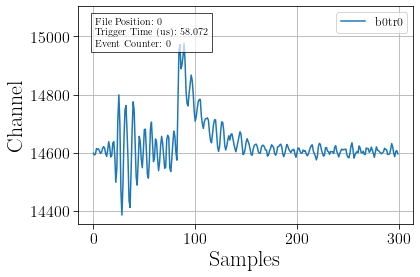

In [4]:
for i in range(0,1):
    tr = df.getNextTrigger()
#     if(i>85):
    tr.display(trName='b0tr0')

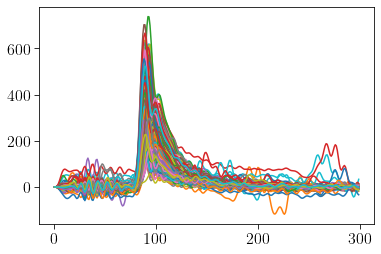

In [80]:
df.file.seek(0)

for i in range(0,200):
    tr = df.getNextTrigger()
    # Save waveform from specified channel ID
    trace = tr.traces['b0tr0'].astype("float")
    array_trace = np.array(np.ones(len(trace)))
    bsl = np.mean(trace[280:299])
    for i in range(len(trace)):
        array_trace[i] = (trace[i]-bsl)
#     array.append(array_trace)
    filtered = scipy.signal.sosfilt(sos, array_trace)
    plt.plot(filtered)
    tr = df.getNextTrigger()

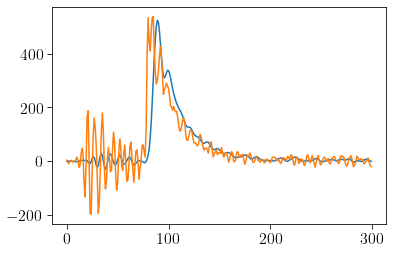

In [82]:
sos = scipy.signal.butter(5, 90, 'lp', fs=1000, output='sos')
filtered = scipy.signal.sosfilt(sos, array_trace)
plt.plot(filtered)
plt.plot(array_trace)

(70.0, 150.0)

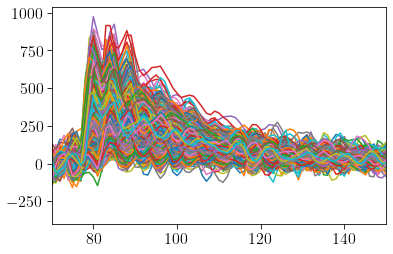

In [83]:
for i in range(0,2000):
    # Save waveform from specified channel ID
    trace = tr.traces['b0tr0'].astype("float")
    array_trace = np.array(np.ones(len(trace)))
    bsl = np.mean(trace[0:20])
    for i in range(len(trace)):
        array_trace[i] = (trace[i]-bsl)
    filtered = scipy.signal.sosfilt(sos, array_trace)
    plt.plot(array_trace)
    tr = df.getNextTrigger()
    
plt.xlim(70,150)

# V-gain curve

In [95]:
V_bias = 55.0
infile_name = "/home/coure/SiPMs_QA/data/SiPM_%s/SiPM_%s.dat"%(SiPM_ID,V_bias)

df = CAENReader.DataFile(infile_name)
outFolder = "/home/coure/SiPMs_QA/results/SiPM_%s/"%(SiPM_ID)

In [96]:
wf_array = []
integ_ADC = []
samples = []

tr = df.getNextTrigger()
while tr is not None:
    trace = tr.traces['b0tr0'].astype("float")
    array_trace = np.array(np.ones(len(trace)))
    bsl = np.mean(trace[280:299])
    for j in range(len(trace)):
        array_trace[j] = (trace[j]-bsl)
    wf_array.append(array_trace)
#     filtered = scipy.signal.sosfilt(sos, array_trace)
    integ_ADC.append(sum(array_trace[70:120]))
    samples.append(np.arange(0,300))
    tr = df.getNextTrigger()

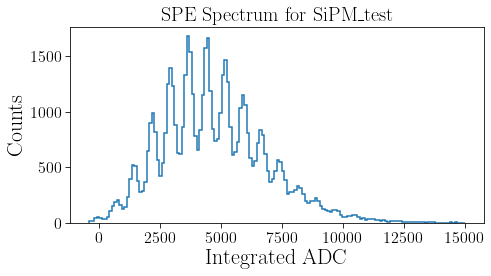

In [97]:
plt.figure(figsize=(7,4))
plt.hist(integ_ADC, bins = 150, histtype="step", lw = 1.5, range = (-400,15000));
plt.ylabel('Counts')
plt.xlabel('Integrated ADC')
plt.title("SPE Spectrum for SiPM_%s"%(SiPM_ID))
plt.tight_layout()
# plt.savefig(outFolder+"SPE_%s.pdf"%(SiPM_ID))
# del(integ_ADC)

## Perform fit

Text(0.5, 0, 'Integrated ADC [p.e]')

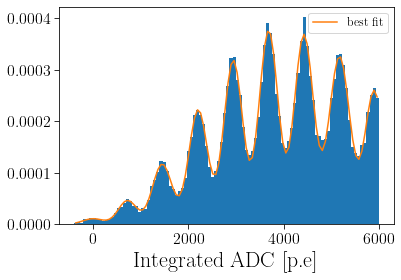

In [42]:
from lmfit.models import GaussianModel, ConstantModel
import scipy.signal
bin_heights, bin_borders, _ = plt.hist(np.array(integ_ADC), bins=100,range=(-400,6000), density=True, );
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=2)
number_of_peaks = len(peaks_in_interval)
amplitude = bin_heights[peaks_in_interval]
width = np.zeros(number_of_peaks) + 100
center = bin_centers[peaks_in_interval]

def make_model(num):
    pref = "f{0}_".format(num)
    model = GaussianModel(prefix = pref)
    model.set_param_hint(pref+'amplitude', value=amplitude[num], min=1E-8, max=1000*amplitude[num])
    model.set_param_hint(pref+'center', value=center[num], min=center[num]-50, max=center[num]+50)
    model.set_param_hint(pref+'sigma', value=width[num], min=0., max=800)
    return model

mod = None
for i in range(len(peaks_in_interval)):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

# offset = ConstantModel()
# offset.set_param_hint('c', value=np.average(bin_heights[-75:]))
mod = mod #+ offset

out=mod.fit(bin_heights, x=bin_centers)
# plt.interactive(True)
# print(out.fit_report())

# plt.hist(np.array(integ_ADC), bins=100,range=(-400,6000), density=True, alpha=0.6);
# plt.scatter(bin_centers[peaks_in_interval],bin_heights[peaks_in_interval], c = "red", alpha = 0.3);

plt.plot(bin_centers, out.best_fit, label='best fit')
# plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
plt.legend()

plt.xlabel("Integrated ADC [p.e]")

Text(0.5, 0, 'Integrated ADC [p.e]')

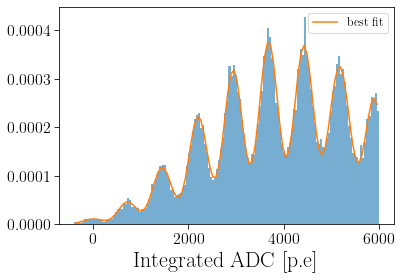

In [43]:
plt.hist(np.array(integ_ADC), bins=150,range=(-400,6000), density=True, alpha=0.6);
# plt.scatter(bin_centers[peaks_in_interval],bin_heights[peaks_in_interval], c = "red", alpha = 0.3);

plt.plot(bin_centers, out.best_fit, label='best fit')
# plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
plt.legend()
plt.xlabel("Integrated ADC [p.e]")

## All together now... altogether now!

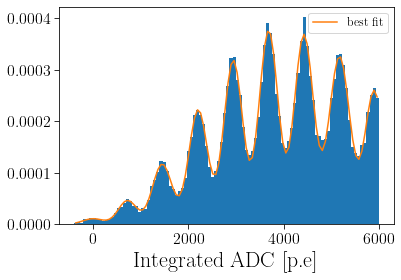

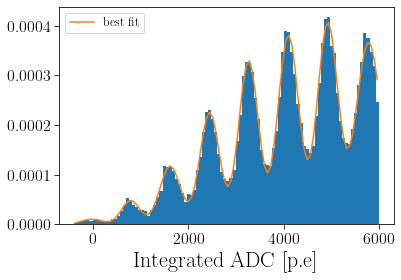

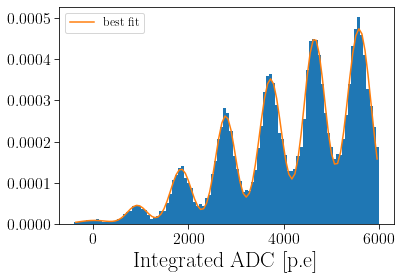

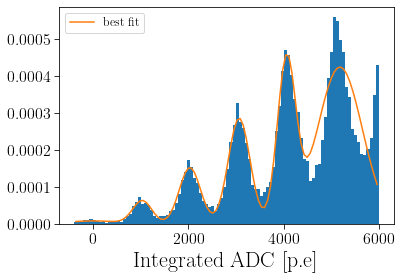

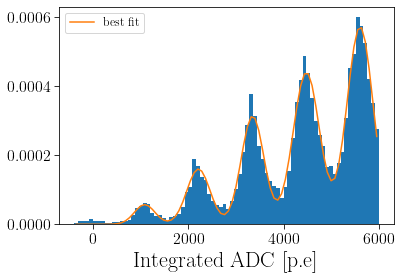

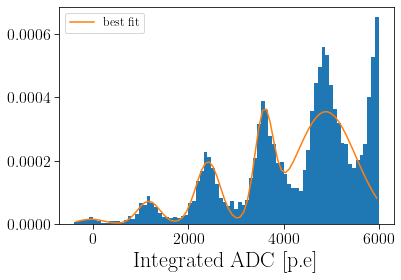

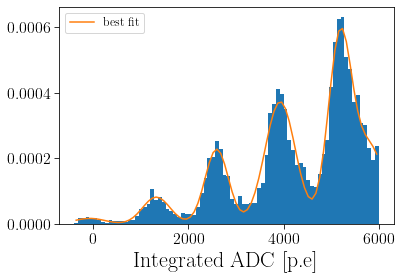

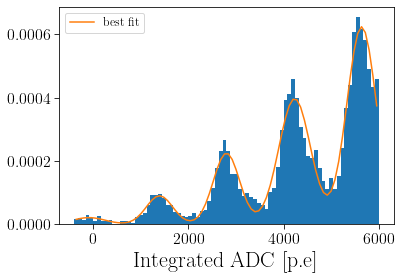

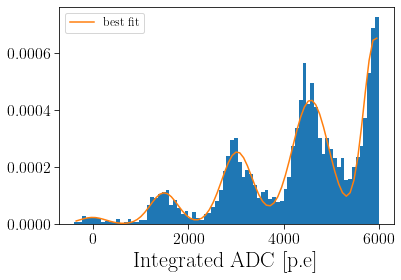

In [140]:
gain = []
SiPM_ID = "test"
bins = 100
for V_bias in np.arange(55.0,59.5,0.5):
    infile_name = "/home/coure/SiPMs_QA/data/SiPM_%s/SiPM_%s.dat"%(SiPM_ID,V_bias)
    df = CAENReader.DataFile(infile_name)

    wf_array = []
    integ_ADC = []
    samples = []

    tr = df.getNextTrigger()
    while tr is not None:
        trace = tr.traces['b0tr0'].astype("float")
        array_trace = np.array(np.ones(len(trace)))
        bsl = np.mean(trace[280:299])
        for j in range(len(trace)):
            array_trace[j] = (trace[j]-bsl)
        wf_array.append(array_trace)
        integ_ADC.append(sum(array_trace[70:120]))
        samples.append(np.arange(0,300))
        tr = df.getNextTrigger()
    
    if(V_bias>56.5):
        bins = 80 
    bin_heights, bin_borders = np.histogram(np.array(integ_ADC), bins=bins,range=(-400,6000), density=True, );
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

    peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=2)
    number_of_peaks = len(peaks_in_interval)
    amplitude = bin_heights[peaks_in_interval]
    width = np.zeros(number_of_peaks) + 100
    center = bin_centers[peaks_in_interval]

    def make_model(num):
        pref = "f{0}_".format(num)
        model = GaussianModel(prefix = pref)
        model.set_param_hint(pref+'amplitude', value=amplitude[num], min=1E-8, max=1000*amplitude[num])
        model.set_param_hint(pref+'center', value=center[num], min=center[num]-50, max=center[num]+50)
        model.set_param_hint(pref+'sigma', value=width[num], min=0., max=800)
        return model

    mod = None
    for i in range(len(peaks_in_interval)):
        this_mod = make_model(i)
        if mod is None:
            mod = this_mod
        else:
            mod = mod + this_mod

    out=mod.fit(bin_heights, x=bin_centers)
    # plt.interactive(True)
    # print(out.fit_report())
    plt.figure()
    plt.hist(np.array(integ_ADC), bins=bins,range=(-400,6000), density=True, );
    plt.plot(bin_centers, out.best_fit, label='best fit')
    # plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
    plt.legend()
    gain.append(out.values["f1_center"]-out.values["f0_center"])
    plt.xlabel("Integrated ADC [p.e]")

In [139]:
out.values["f1_center"]-out.values["f0_center"]

1503.4300145783168

In [142]:
data = pd.DataFrame(data = {"voltages":np.arange(55.0,59.5,0.5), "gain":gain})

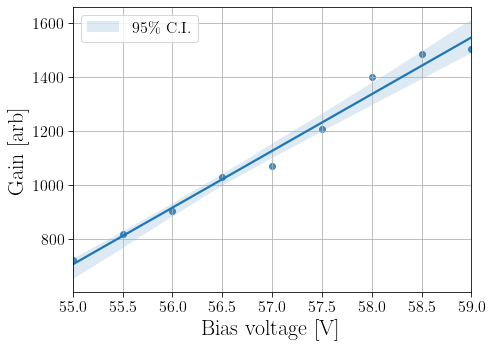

In [143]:
plt.figure(figsize=(7,5))
# plt.scatter(voltages, values)
ax = sns.regplot(data = data, x = "voltages", y = "gain")
plt.xlabel("Bias voltage [V]")
plt.ylabel("Gain [arb]")
ax.collections[1].set_label('$95\%$ C.I.')
plt.grid()
plt.legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
# plt.savefig("./Dumpster/linearFit_gainVCurve.pdf")